## Project Results
---
The following is a summary of model selection and results as run via the *03_do_modeling.py* script.

### Overview
Suicide is the 10th leading cause of death worldwide. With diverse biological and social determinants, suicidal behavior and ideation present a complex, global risk to public health across all age groups. 

This project looks to combine personal interest in the social determinants of suicide, webscraping data, and statistical modeling. Through the scraping of 2016 suicide rates by country, identification of mean suicide rates across the acquired countries and employement of classification and ensemble learning algorithms, countries are classified as above or below identified average rates according to select social factors. 

For a deeper look at project data sources and layout, refer to project *README.ipynb*.

---

To get started, let's load some initial libraries and functions...

In [1]:
import os
import sys  
sys.path.insert(0, '/Users/emilyburns/Documents/Data_Science/projects/web_scraping_wiki/code/script/functions')
import funs_do_modeling as funs
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

Next, we'll import the previously cleaned dataframe and take an initial look at the available data... 

(refer to *01_do_webscraping.py* and *02_do_data_cleaning.py* for data collection and cleaning specifics)

In [23]:
df = pd.read_csv('/Users/emilyburns/Documents/Data_Science/projects/web_scraping_wiki/data/processed_data/all_project_data_clean.csv')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   2016_Suicide_Rate            192 non-null    float64
 1   2015_Disorder_Prevalence     192 non-null    float64
 2   2015_Unemployment            192 non-null    float64
 3   2015_Healthcare_Expenditure  192 non-null    float64
 4   2015_Gender_Ratio            192 non-null    float64
 5   Country                      192 non-null    object 
 6   Code                         191 non-null    object 
 7   Suicide_Classification       192 non-null    object 
dtypes: float64(5), object(3)
memory usage: 12.1+ KB


In [25]:
df.head()

,2016_Suicide_Rate,2015_Disorder_Prevalence,2015_Unemployment,2015_Healthcare_Expenditure,2015_Gender_Ratio,Country,Code,Suicide_Classification
0,9.052091,16.909515,8.864000,60.0,48.454558,Afghanistan,AFG,Below
1,5.600000,10.883379,17.080000,266.0,49.514599,Albania,ALB,Below
2,3.300000,14.523882,11.200000,292.0,49.504141,Algeria,DZA,Below
3,8.900000,12.396676,7.281000,109.0,50.991010,Angola,AGO,Below
4,0.500000,13.221361,10.450397,657.0,52.024498,Antigua and Barbuda,ATG,Below


Next, to ensure the replicability of our model findings, we'll set a random seed prior to further analyses. 

In [26]:
random.seed(101)

Let's also address our features. As this is a relatively small dataset (there are only so many countries on Earth), we'll only choose a few social determinants that have been implicated in increased suicidal behavior risk in previous research (see project *README.ipynb* or end of current file for references) in order to mitigate risk of overfitting our data. 

The selected features (2015 mental disorder prevalence, unemployement rates, healthcare expenditure and gender ratios by country) and suicide rate outcome are calculated on widely varying measures. In order to accurately interpret our model results, we'll first scale each of these continuous variables.

In [27]:
from sklearn.preprocessing import StandardScaler

col_names = ['2016_Suicide_Rate', '2015_Disorder_Prevalence', '2015_Unemployment', 
             '2015_Healthcare_Expenditure', '2015_Gender_Ratio']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

df[col_names] = features

In [29]:
df['Suicide_Classification'] = df['Suicide_Classification'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   2016_Suicide_Rate            192 non-null    float64 
 1   2015_Disorder_Prevalence     192 non-null    float64 
 2   2015_Unemployment            192 non-null    float64 
 3   2015_Healthcare_Expenditure  192 non-null    float64 
 4   2015_Gender_Ratio            192 non-null    float64 
 5   Country                      192 non-null    object  
 6   Code                         191 non-null    object  
 7   Suicide_Classification       192 non-null    category
dtypes: category(1), float64(5), object(2)
memory usage: 10.9+ KB


After scaling our features, we'll split our dataset into training and test sets in preparation for predictive modeling. The categorical 'Suicide_Classification' feature previously engineered during the data cleaning process will be utilized as the classification outcome variable, while the '2015_Disorder_Prevalence', '2015_Unemployment', '2015_Healthcare_Expenditure', and '2015_Gender_Ratio' will be utilized as the predictive variables. 

For an in-depth description of the dataset's variables, refer to the project *'project_data_dictionary.ipynb'*

In [30]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:5]
y = df['Suicide_Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [10]:
print("Number of countries in training data: {}".format(len(X_train))) 
print("Number of countries in test data: {}".format(len(X_test))) 

Number of countries in training data: 134
Number of countries in test data: 58


A common problem encountered in classification is class imbalance. Highly imbalanced classes in the outcome variable, especially in small samples, can result in low predictive accuracy for the less frequent class. Let's take a look at our own class balance before moving onto modeling.

In [31]:
df['Suicide_Classification'].value_counts()

Below    103
Above     89
Name: Suicide_Classification, dtype: int64

In [12]:
y_train.value_counts()

Below    75
Above    59
Name: Suicide_Classification, dtype: int64

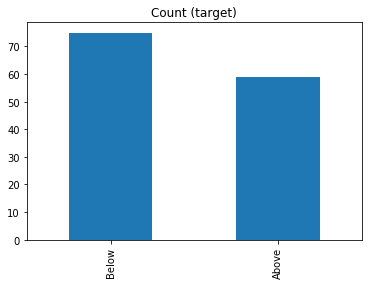

In [13]:
y_train.value_counts().plot(kind='bar', title='Count (target)')

The 'Suicide_Classification' classes aren't incredibly unbalanced, but, given the small nature of our sample, we'll go ahead and use SMOTE to account for the difference in the training set. 

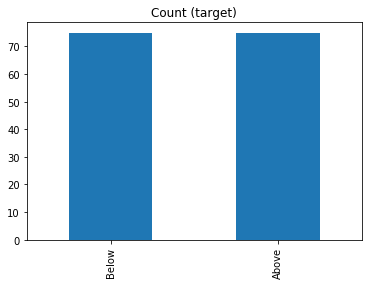

In [34]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

y_train_SMOTE.value_counts().plot(kind='bar', title='Count (target)')

Now that all of the data preprocessing steps have been addressed, we'll move onto statistical modeling. Again, because this is a small dataset, we'll be using simple algorithms in order to avoid overfitting and poor test performance. 

In this project, we'll use k-NN Classification, logistic regression and decision tree classification algorithms, all of which can generalize findings from datasets with a low number of observations relatively well.

### k-NN Classification Model
---

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

In [35]:
knn = KNeighborsClassifier()

knn_grid_params = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance']}

knn_gscv = GridSearchCV(knn, 
                        knn_grid_params,
                        verbose = 1,
                        cv=5, 
                        n_jobs = -1)

knn_results = knn_gscv.fit(X_train_SMOTE, y_train_SMOTE)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    2.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished


In [36]:
funs.TrainingResults(knn_results)

Best estimator:
KNeighborsClassifier(n_neighbors=7, weights='distance')

Best cross-validation score: 0.75

Best parameters:
{'n_neighbors': 7, 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005599,0.000695,0.005559,0.000691,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.666667,0.733333,0.733333,0.700000,0.733333,0.713333,0.026667,10
1,0.007685,0.003667,0.006677,0.002210,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.633333,0.733333,0.733333,0.733333,0.733333,0.713333,0.040000,9
2,0.006255,0.002361,0.007019,0.003295,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.666667,0.733333,0.800000,0.766667,0.733333,0.740000,0.044222,3
3,0.005318,0.001188,0.005842,0.001770,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.633333,0.733333,0.766667,0.833333,0.733333,0.740000,0.064636,3
4,0.007759,0.003387,0.006638,0.001953,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.666667,0.733333,0.800000,0.766667,0.766667,0.746667,0.045216,2



---
From our training results, we can see that the best k-NN estimator has 7 neighbors using 'distance' as its weight. Although the model returns a 75% cross-validation score, we'll expect this to fall during prediction given the minimal information in the even smaller test set. 

---

In [37]:
funs.TestResults(knn_gscv, X_test, y_test)

Test set predictions: 
['Above' 'Above' 'Below' 'Below' 'Below' 'Below' 'Below' 'Below' 'Below'
 'Above' 'Above' 'Below' 'Above' 'Below' 'Below' 'Below' 'Below' 'Below'
 'Above' 'Above' 'Above' 'Below' 'Above' 'Above' 'Below' 'Below' 'Below'
 'Below' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Below' 'Above'
 'Below' 'Above' 'Below' 'Above' 'Below' 'Below' 'Below' 'Above' 'Above'
 'Above' 'Below' 'Below' 'Above' 'Above' 'Above' 'Below' 'Above' 'Below'
 'Above' 'Below' 'Below' 'Below']


Test set accuracy: 0.66


Confusion matrix: 
[[17 13]
 [ 7 21]]


Classification report: 
              precision    recall  f1-score   support

       Above       0.71      0.57      0.63        30
       Below       0.62      0.75      0.68        28

    accuracy                           0.66        58
   macro avg       0.66      0.66      0.65        58
weighted avg       0.66      0.66      0.65        58



Chance: ROC AUC=0.500
Model: ROC AUC=0.785


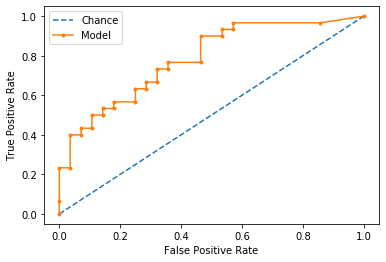

In [38]:
funs.ROCPlot(knn_gscv, X_test, y_test)

---
From the results above, we can see the accuracy fell to 66% but that the model stills performs better than chance. The ROC AUC is .785, which is a little higher than 'acceptable.' Let's look how a logistic regression model performs in comparison. 

---

### Logistic Regression Model
---

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
logreg = LogisticRegression(random_state=101)

logreg_grid_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
                      'penalty': ['l1', 'l2']}

logreg_gscv = GridSearchCV(logreg,
                           logreg_grid_params,
                           cv=5,
                           verbose =1,
                           n_jobs = -1)

logreg_results = logreg_gscv.fit(X_train_SMOTE, y_train_SMOTE)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished


In [41]:
funs.TrainingResults(logreg_results)

Best estimator:
LogisticRegression(C=10, random_state=101)

Best cross-validation score: 0.69

Best parameters:
{'C': 10, 'penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001795,0.000258,0.000000,0.000000,0.001,l1,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
1,0.011053,0.002461,0.003938,0.001083,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.6,0.766667,0.666667,0.733333,0.6,0.673333,0.067987,4
2,0.001956,0.000435,0.000000,0.000000,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,0.008838,0.001814,0.004487,0.002033,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.6,0.733333,0.700000,0.700000,0.6,0.666667,0.055777,6
4,0.000953,0.000103,0.000000,0.000000,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


---

From the results above, we can see the logistic regression model performed slightly worse than the k-NN model with a cross-validation score of 69%. The regularization parameter C of the model was best set to 10, with the penality best set to L2 (ridge regression).

---

In [42]:
funs.TestResults(logreg_gscv, X_test, y_test)

Test set predictions: 
['Above' 'Above' 'Below' 'Above' 'Above' 'Below' 'Below' 'Above' 'Below'
 'Above' 'Below' 'Above' 'Below' 'Below' 'Below' 'Above' 'Below' 'Below'
 'Above' 'Above' 'Below' 'Below' 'Above' 'Below' 'Below' 'Below' 'Below'
 'Above' 'Above' 'Above' 'Below' 'Below' 'Below' 'Above' 'Below' 'Above'
 'Below' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Above' 'Below'
 'Above' 'Above' 'Above' 'Above' 'Below' 'Above' 'Above' 'Above' 'Below'
 'Above' 'Below' 'Above' 'Below']


Test set accuracy: 0.64


Confusion matrix: 
[[19 11]
 [10 18]]


Classification report: 
              precision    recall  f1-score   support

       Above       0.66      0.63      0.64        30
       Below       0.62      0.64      0.63        28

    accuracy                           0.64        58
   macro avg       0.64      0.64      0.64        58
weighted avg       0.64      0.64      0.64        58



Chance: ROC AUC=0.500
Model: ROC AUC=0.700


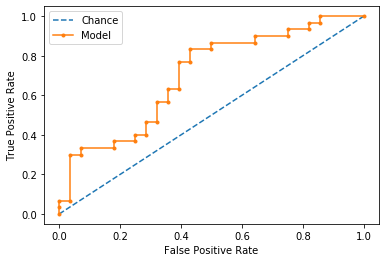

In [43]:
funs.ROCPlot(logreg_gscv, X_test, y_test)

---
From the results above, we can see the accuracy fell to 64% but that the model stills performs better than chance. The ROC AUC is .70, which is 'acceptable' and also lower performance than the k-NN model. Let's look how a decision tree model performs in comparison. 

---

### Decision Tree Model
---

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
tree = DecisionTreeClassifier()

tree_grid_params = {'criterion': ['gini', 'entropy'],
                    'max_depth': [2,4,6,8,10]}

tree_gscv = GridSearchCV(tree,
                           tree_grid_params,
                           cv=5,
                           verbose =1,
                           n_jobs = -1)

tree_results = tree_gscv.fit(X_train_SMOTE, y_train_SMOTE)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


In [46]:
funs.TrainingResults(tree_gscv)

Best estimator:
DecisionTreeClassifier(criterion='entropy', max_depth=8)

Best cross-validation score: 0.73

Best parameters:
{'criterion': 'entropy', 'max_depth': 8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006997,0.004543,0.003036,0.000505,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.633333,0.733333,0.733333,0.633333,0.500000,0.646667,0.085894,9
1,0.006169,0.002746,0.009915,0.011821,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.666667,0.800000,0.800000,0.600000,0.633333,0.700000,0.084327,5
2,0.013786,0.010780,0.007764,0.008552,gini,6,"{'criterion': 'gini', 'max_depth': 6}",0.700000,0.833333,0.800000,0.766667,0.566667,0.733333,0.094281,3
3,0.009727,0.005029,0.003429,0.000703,gini,8,"{'criterion': 'gini', 'max_depth': 8}",0.700000,0.833333,0.766667,0.666667,0.633333,0.720000,0.071802,4
4,0.009074,0.003243,0.004310,0.002181,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.666667,0.800000,0.700000,0.600000,0.566667,0.666667,0.081650,8


---
The decision tree model has a cross-validation training score of 73%, better than the logistic regression model but still behind the k-NN model. The max-depth of the tree is best set at 6, the lower depth a good method for mitigating overfitting the data in tree-based models.

To better visualize the model, we can use the graphviz module as below prior to assessing model performance.

---

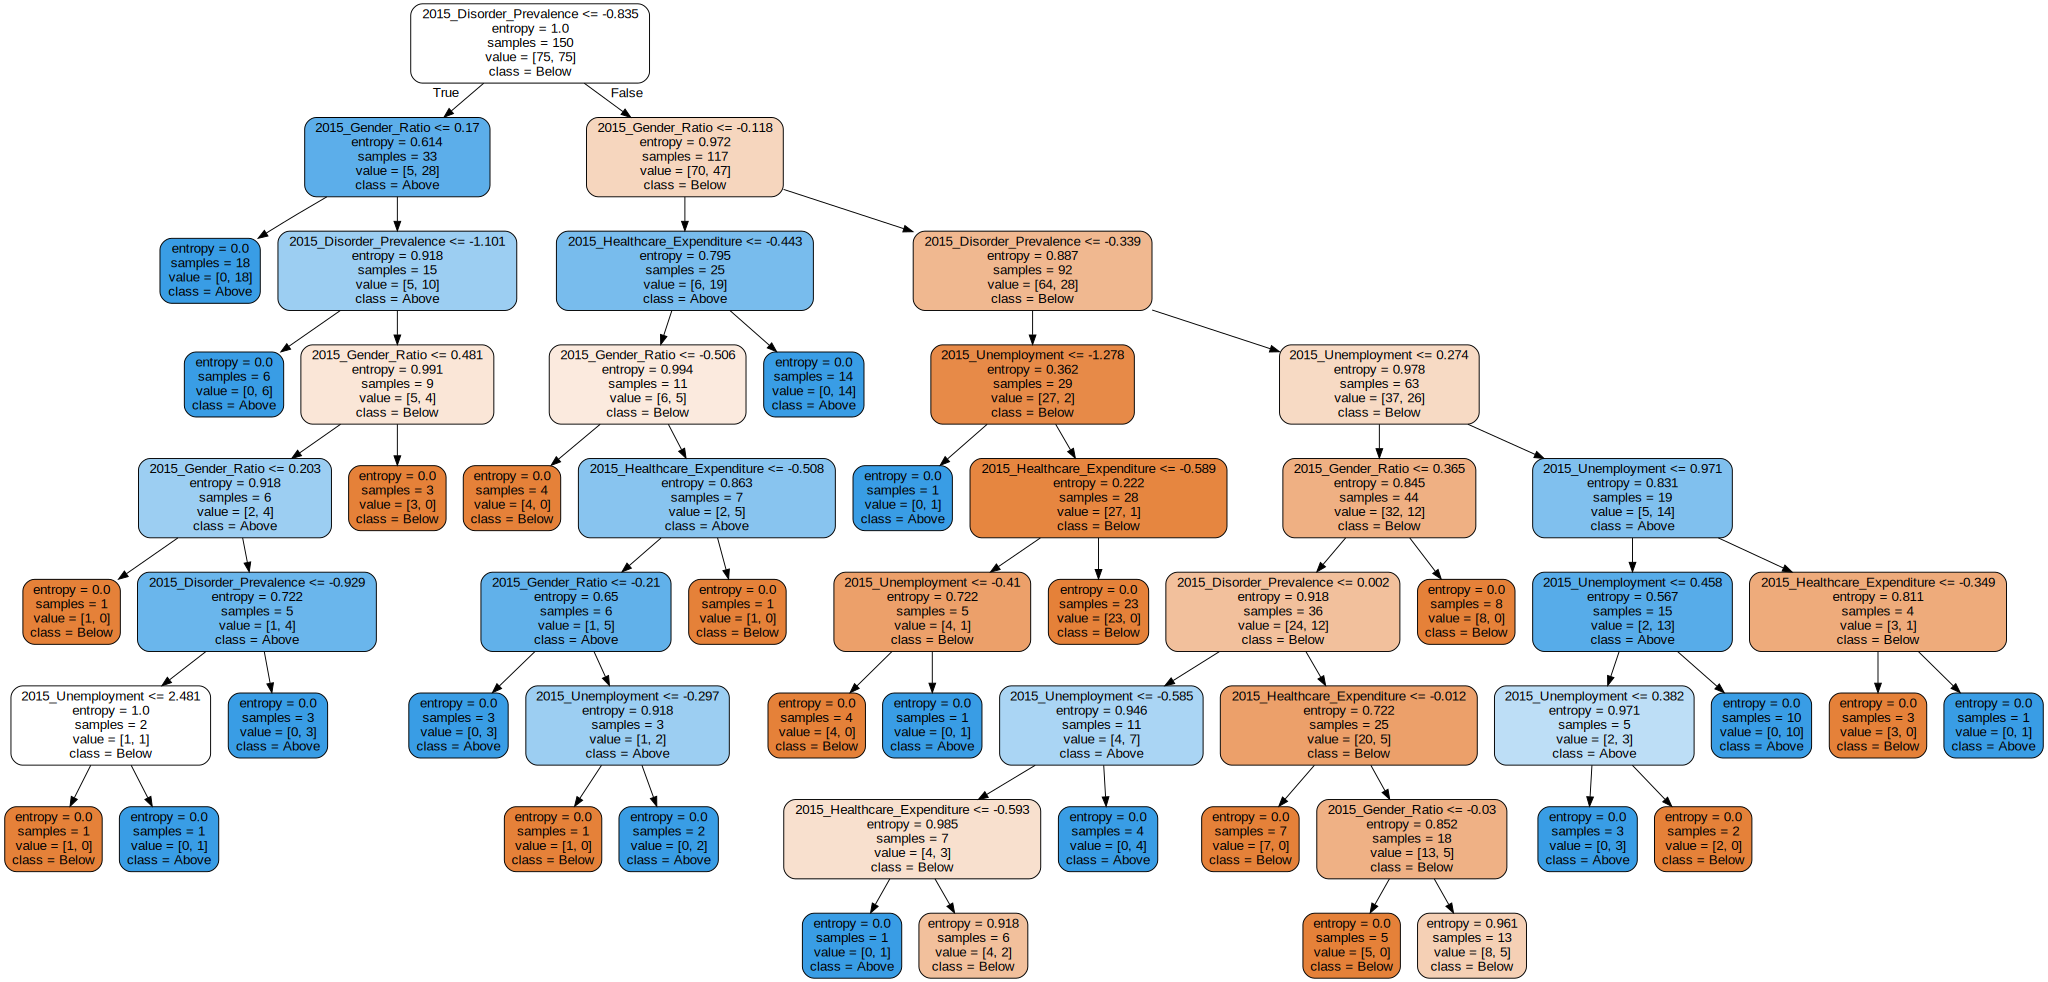

In [48]:
import graphviz
from sklearn import tree

feature_names = X_train.columns
dot_data = tree.export_graphviz(tree_gscv.best_estimator_, out_file=None, 
            filled=True, rounded=True, feature_names=feature_names, class_names=['Below','Above'])

graph = graphviz.Source(dot_data)  
graph   

In [49]:
funs.TestResults(tree_gscv, X_test, y_test)

Test set predictions: 
['Above' 'Above' 'Above' 'Below' 'Below' 'Below' 'Below' 'Above' 'Below'
 'Above' 'Below' 'Above' 'Below' 'Below' 'Below' 'Below' 'Below' 'Above'
 'Above' 'Above' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Below'
 'Above' 'Above' 'Below' 'Above' 'Below' 'Above' 'Above' 'Below' 'Above'
 'Above' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Above' 'Below'
 'Below' 'Above' 'Below' 'Above' 'Above' 'Above' 'Above' 'Above' 'Below'
 'Above' 'Above' 'Above' 'Below']


Test set accuracy: 0.66


Confusion matrix: 
[[21  9]
 [11 17]]


Classification report: 
              precision    recall  f1-score   support

       Above       0.66      0.70      0.68        30
       Below       0.65      0.61      0.63        28

    accuracy                           0.66        58
   macro avg       0.66      0.65      0.65        58
weighted avg       0.66      0.66      0.65        58



Chance: ROC AUC=0.500
Model: ROC AUC=0.614


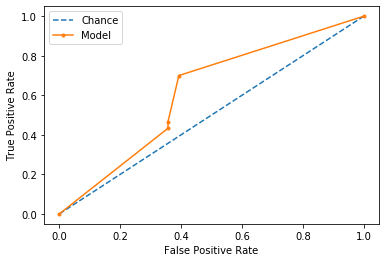

In [50]:
funs.ROCPlot(tree_gscv, X_test, y_test)

---
From the results above, we can see the accuracy fell to 69% but that the model stills performs better than chance and has the best test performance of all the utilized models. The ROC AUC is, however, the lowest of the three models at .675, which is still considered 'acceptable.'

---

Ensemble learning is a great tool for improving predictive performance across several constituent learning algorithms. As the three utilized models above did not have an exceedingly high performance accuracy, we'll utilize the voting and stacking ensemble learning algorithms to combine the k-NN, logistic regression and decision tree's computational power into a single model. 

### Voting Classification Model
---

For the voting classifcation model, we'll use the previously modeled logistic regression, k-NN classification and decision tree cross-validated algorithms and use the fitted data to predict the combined performance.

In [51]:
from sklearn.ensemble import VotingClassifier

In [52]:
voting_clf = VotingClassifier(estimators=[('lr', logreg_gscv), 
                                          ('knn', knn_gscv), 
                                          ('tree', tree_gscv)], voting='hard') 

for clf in (logreg_gscv, tree_gscv, knn_gscv, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV 0.603448275862069
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


GridSearchCV 0.7068965517241379
Fitting 5 folds for each of 10 candidates, totalling 50 fits
GridSearchCV 0.6724137931034483
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
VotingClassifier 0.6551724137931034


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


---
The fitted model returns the gridsearch results for each included algorithm, as well as the final voting classifier training performance. The voting classifier bumped up the performance to 76%, slightly better than the single k-NN model's training performance.

---

In [53]:
funs.TestResults(voting_clf, X_test, y_test)

Test set predictions: 
['Below' 'Above' 'Below' 'Below' 'Below' 'Below' 'Below' 'Above' 'Below'
 'Below' 'Below' 'Below' 'Below' 'Below' 'Below' 'Below' 'Below' 'Below'
 'Above' 'Above' 'Below' 'Below' 'Above' 'Below' 'Below' 'Below' 'Below'
 'Below' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Below' 'Above'
 'Below' 'Above' 'Below' 'Above' 'Below' 'Below' 'Below' 'Above' 'Below'
 'Below' 'Below' 'Below' 'Above' 'Above' 'Below' 'Above' 'Below' 'Below'
 'Above' 'Below' 'Below' 'Below']


Test set accuracy: 0.66


Confusion matrix: 
[[13 17]
 [ 3 25]]


Classification report: 
              precision    recall  f1-score   support

       Above       0.81      0.43      0.57        30
       Below       0.60      0.89      0.71        28

    accuracy                           0.66        58
   macro avg       0.70      0.66      0.64        58
weighted avg       0.71      0.66      0.64        58



--- 
From the above results, the accuracy of our prediction improved to 76% which is better than any of the single algorithms previously run. 

We'll run another ensemble learning algorithm called stacking, in which we'll use the decision tree and logistic regression models as base models and the k-NN classifier as the meta-classifier.

---

### Stacking Classification Model
---

In [ ]:
from mlxtend.classifier import StackingCVClassifier

In [82]:
stacking_clf = StackingCVClassifier(classifiers = [DecisionTreeClassifier(), LogisticRegression()],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = KNeighborsClassifier())

classifiers = {"lr": KNeighborsClassifier(),
               "knn": LogisticRegression(),
               "stack": stacking_clf}

In [83]:
for key in classifiers:
    classifier = classifiers[key]
    classifier.fit(X_train_SMOTE, y_train_SMOTE)
    classifiers[key] = classifier

In [84]:
results = pd.DataFrame()

for key in classifiers:
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    results[f"{key}"] = y_pred
    
results["actual_value"] = y_test

In [85]:
results.head(10)

,lr,knn,stack,actual_value
0,0.4,0.461173,0.8,NaN
1,0.4,0.299140,0.0,Below
2,0.8,0.701938,0.8,NaN
3,0.6,0.465751,0.6,NaN
4,1.0,0.352367,0.4,Below
5,1.0,0.679447,0.8,NaN
6,0.6,0.923943,0.6,NaN
7,0.4,0.332105,0.0,NaN
8,0.6,0.847328,0.4,NaN
9,0.2,0.433530,0.6,NaN


---
The stacking looks like its performing relatively well but to even further boost the model's performance, we'll add a gridsearch with various parameters according to algorithm and cross-validation. 

---

In [87]:
params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
          'decisiontreeclassifier__max_depth': [2,4,6,8,10],
          'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
          'meta_classifier__n_neighbors': [3, 5, 7, 9, 11],
          'meta_classifier__weights': ['uniform', 'distance']
          }

grid = GridSearchCV(estimator=stacking_clf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)

grid.fit(X_train_SMOTE, y_train_SMOTE)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

0.607 +/- 0.07 {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 0.001, 'meta_classifier__n_neighbors': 3, 'meta_classifier__weights': 'uniform'}
0.607 +/- 0.07 {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 0.001, 'meta_classifier__n_neighbors': 3, 'meta_classifier__weights': 'distance'}
0.600 +/- 0.08 {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 0.001, 'meta_classifier__n_neighbors': 5, 'meta_classifier__weights': 'uniform'}
0.600 +/- 0.08 {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 0.001, 'meta_classifier__n_neighbors': 5, 'meta_classifier__weights': 'distance'}
0.593 +/- 0.06 {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 0.001, 'meta_classifier__n_neighbors': 7, 'm

In [88]:
print('Best parameters: %s' % grid.best_params_)
print('\nAccuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 4, 'logisticregression__C': 1, 'meta_classifier__n_neighbors': 7, 'meta_classifier__weights': 'uniform'}

Accuracy: 0.77


---
The above training results indicate that the best parameters (decision tree using entropy and depth of 4, logistic regression using C of 1, and k-NN meta classifier using 7 neighbors and uniform weight) lead to an accuracy of 77%. Again, we expect this performance to fall during testing, but the training performance is the best of all the models utilized so far.

---

In [89]:
funs.TestResults(stacking_clf, X_test, y_test)

Test set predictions: 
['Below' 'Above' 'Below' 'Below' 'Above' 'Below' 'Below' 'Above' 'Above'
 'Below' 'Below' 'Above' 'Below' 'Below' 'Below' 'Below' 'Below' 'Below'
 'Below' 'Above' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Below'
 'Below' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Below' 'Above'
 'Above' 'Above' 'Below' 'Above' 'Below' 'Below' 'Above' 'Above' 'Below'
 'Below' 'Above' 'Below' 'Above' 'Above' 'Below' 'Above' 'Below' 'Below'
 'Above' 'Above' 'Above' 'Below']


Test set accuracy: 0.67


Confusion matrix: 
[[18 12]
 [ 7 21]]


Classification report: 
              precision    recall  f1-score   support

       Above       0.72      0.60      0.65        30
       Below       0.64      0.75      0.69        28

    accuracy                           0.67        58
   macro avg       0.68      0.68      0.67        58
weighted avg       0.68      0.67      0.67        58



Chance: ROC AUC=0.500
Model: ROC AUC=0.710


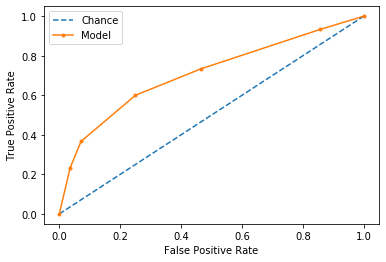

In [90]:
funs.ROCPlot(stacking_clf, X_test, y_test)

---
Although the stacking model had the best training results of all the algorithms, the testing performance is actually relatively poor in comparison with an accuracy of 67% and an ROC AUC of .71, suggesting that the stacking model was overfitting the data during training. 

---

### Results Summary
---
Of the all the models run throughout the project, the voting classifier appears to return the most successful results, with a test set accuracy of 76%. 

The model had a higher rate of false positives than false negatives, indicating the model incorrectly predicts countries as being above the average global suicide rates when they are actually below the average rate at higher rate than incorrectly classifying countries as below the average global rate when than are actually above. Given the significantly negative impact of suicide, this prediction trend is in the preferred direction. In terms of crucial psychiatric care, erring on the side of over-flagging high-risk populations and more preventative care is preferrential to under-flagging and employing reactive, curative care.

Visualization from both the Decision Tree Classification model and previous exploratory data analysis (refer to *01_data_exploration.ipynb*) also suggest that, of all the included determinants, mental disorder prevalence from the previous is most strongly associated with country suicide rates of the following year, such that, as mental disorder prevalence increases, suicide rates likewise increase. Gender ratio, healthcare expenditure and unemployement rates of the previous year follow in association respectively. Findings also suggest that social determinants can be utilized in preemptive identification of populations at risk of suicidal action the following year.

Suicide is a complex and oftentimes highly stigmatized health risk. Above model findings should be considered strictly in context of current project with caveats of small sample size, varying data collection sources, and model simplicity despite known complexity of suicidal behavior acknowledged. 

#### References
* Ferretti, F., & Coluccia, A. (2009). Socio-economic factors and suicide rates in European Union countries. Legal Medicine, 11, S92–S94. https://doi.org/10.1016/j.legalmed.2009.01.014 
* Milner, A., Page, A., & LaMontagne, A. D. (2013). Long-Term Unemployment and Suicide: A Systematic Review and Meta-Analysis. PLoS ONE, 8(1), e51333. https://doi.org/10.1371/journal.pone.0051333
* Too, L. S., Spittal, M. J., Bugeja, L., Reifels, L., Butterworth, P., & Pirkis, J. (2019). The association between mental disorders and suicide: A systematic review and meta-analysis of record linkage studies. Journal of Affective Disorders, 259, 302–313. https://doi.org/10.1016/j.jad.2019.08.054
* Freeman, A., Mergl, R., Kohls, E., Székely, A., Gusmao, R., Arensman, E., Koburger, N., Hegerl, U., & Rummel-Kluge, C. (2017). A cross-national study on gender differences in suicide intent. BMC Psychiatry, 17(1). https://doi.org/10.1186/s12888-017-1398-8